In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table
from preprocessing import process_diagnoses

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to the MIMIC-III database
con = create_connection()

In [4]:
query = \
"""
SELECT d1.hadm_id, d1.seq_num, d1.icd9_code, d2.short_title
	FROM diagnoses_icd AS d1
	JOIN d_icd_diagnoses AS d2
	ON d1.icd9_code = d2.icd9_code;
"""
diagnoses = query_data(query, con)
diagnoses.head()

,hadm_id,seq_num,icd9_code,short_title
0,172335,1,40301,Mal hyp kid w cr kid V
1,172335,2,486,"Pneumonia, organism NOS"
2,172335,3,58281,Chr nephritis in oth dis
3,172335,4,5855,Chron kidney dis stage V
4,172335,5,4254,Prim cardiomyopathy NEC


### 1. Data Cleaning - Short Title

In [5]:
diagnoses['short_title'] = diagnoses['short_title'].apply(process_diagnoses.clean_text)

### 2. Grouping diagnoses based on ICD9 Code

>001-139	Infectious And Parasitic Diseases
>140-239	Neoplasms
>240-279	Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
>280-289	Diseases Of The Blood And Blood-Forming Organs
>290-319	Mental Disorders
>320-389	Diseases Of The Nervous System And Sense Organs
>390-459	Diseases Of The Circulatory System
>460-519	Diseases Of The Respiratory System
>520-579	Diseases Of The Digestive System
>580-629	Diseases Of The Genitourinary System
>630-679	Complications Of Pregnancy, Childbirth, And The Puerperium
>680-709	Diseases Of The Skin And Subcutaneous Tissue
>710-739	Diseases Of The Musculoskeletal System And Connective Tissue
>740-759	Congenital Anomalies
>760-779	Certain Conditions Originating In The Perinatal Period
>780-799	Symptoms, Signs, And Ill-Defined Conditions
>800-999	Injury And Poisoning
>V01-V91	Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services
>E000-E999	Supplementary Classification Of External Causes Of Injury And Poisoning

In [6]:
diagnoses['diagnosis_group'] = diagnoses['icd9_code'].apply(process_diagnoses.group_diagnoses)
diagnoses.head()

,hadm_id,seq_num,icd9_code,short_title,diagnosis_group
0,172335,1,40301,mal hyp kid w cr kid v,Diseases Of The Circulatory System
1,172335,2,486,pneumonia organism nos,Diseases Of The Respiratory System
2,172335,3,58281,chr nephritis in oth dis,Diseases Of The Genitourinary System
3,172335,4,5855,chron kidney dis stage v,Diseases Of The Genitourinary System
4,172335,5,4254,prim cardiomyopathy nec,Diseases Of The Circulatory System


In [7]:
# Get all unique diagnosis categories
icd_categories = list(process_diagnoses.get_categories().keys())

# Get the patient stay data
df = pd.read_csv('../dataset/patient_stay_data.csv')

# For each category create a new column in the admissions dataframe
for category in icd_categories:
     df[category] = df['hadm_id'].isin(diagnoses[diagnoses['diagnosis_group'] == category]['hadm_id'])

# Convert the boolean values to integers (0 or 1)
df[icd_categories] = df[icd_categories].astype(int)
df.head()

,subject_id,hadm_id,admission_type,admission_location,ethnicity,hospital_expire_flag,total_los,gender,expire_flag,age_at_admission,...,Diseases Of The Genitourinary System,Complications Of Pregnancy Childbirth And The Puerperium,Diseases Of The Skin And Subcutaneous Tissue,Diseases Of The Musculoskeletal System And Connective Tissue,Congenital Anomalies,Certain Conditions Originating In The Perinatal Period,Symptoms Signs And Ill-Defined Conditions,Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,Supplementary Classification Of External Causes Of Injury And Poisoning
0,22,165315,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,0,1.14,F,0,65,...,0,0,0,0,0,0,0,1,0,1
1,23,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,0,5.50,M,0,71,...,1,0,0,0,0,0,0,0,1,0
2,23,124321,EMERGENCY,TRANSFER,WHITE,0,6.77,M,0,75,...,0,0,0,0,0,0,1,0,1,0
3,24,161859,EMERGENCY,TRANSFER,WHITE,0,2.86,M,0,39,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,0,3.53,M,0,59,...,0,0,0,0,0,0,0,0,0,0


### Distribution of Diagnoses Categories

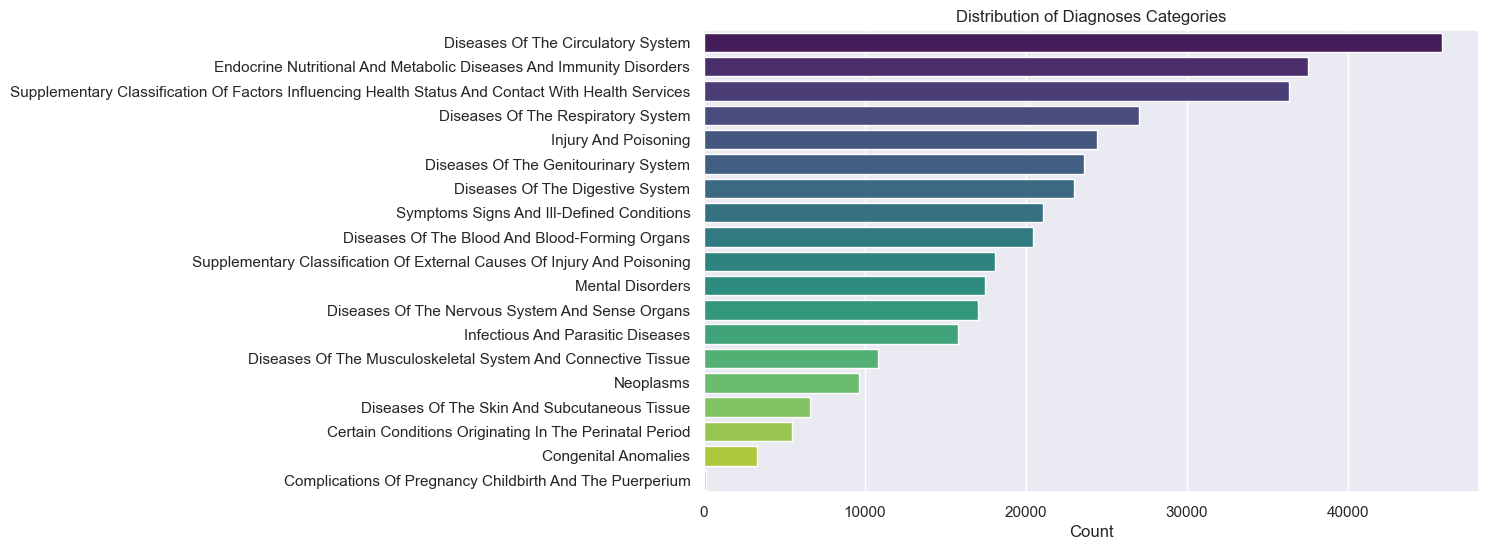

In [8]:
# Get diagnosis category column names

# Calculate the sum for each diagnosis category
diagnosis_counts = df[icd_categories].sum().sort_values(ascending=False)

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.barplot(y=diagnosis_counts.index, x=diagnosis_counts.values, palette="viridis")
plt.title('Distribution of Diagnoses Categories')
plt.xlabel('Count')
plt.show()

### Mortality Rate in each diagnosis category

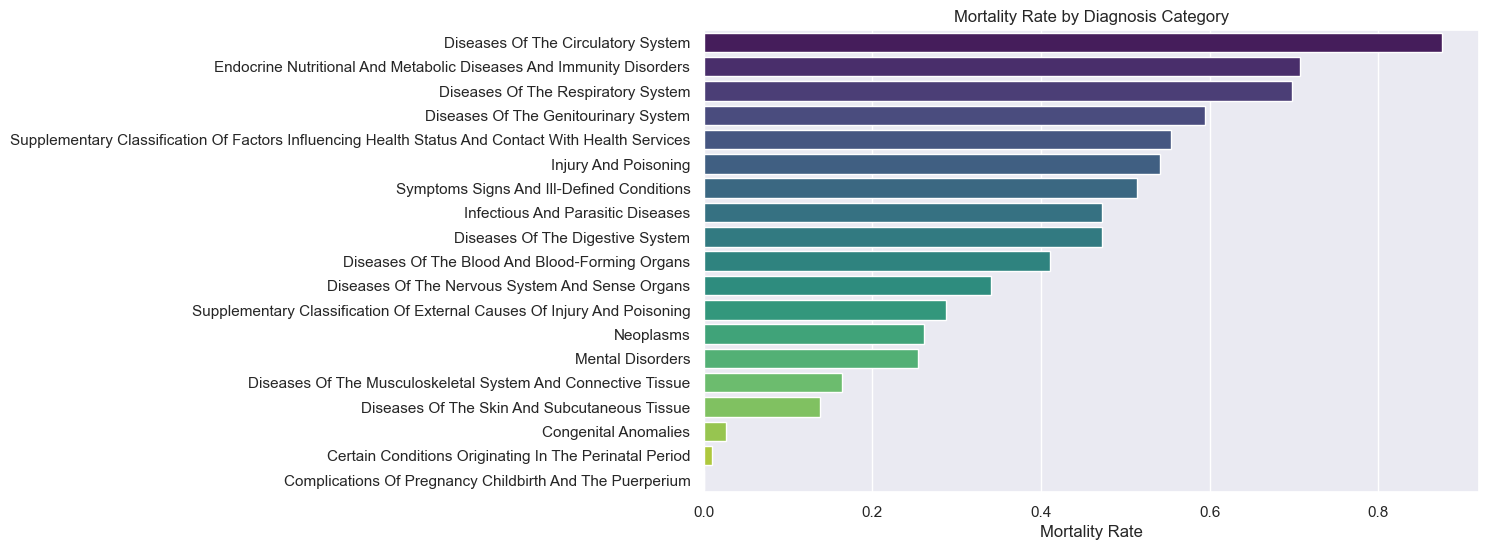

In [9]:
mortality_rates = df[df['hospital_expire_flag'] == 1][icd_categories].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(y=mortality_rates.index, x=mortality_rates.values, palette="viridis")
plt.title('Mortality Rate by Diagnosis Category')
plt.xlabel('Mortality Rate')
plt.show()

### Patient Age in each diagnosis category

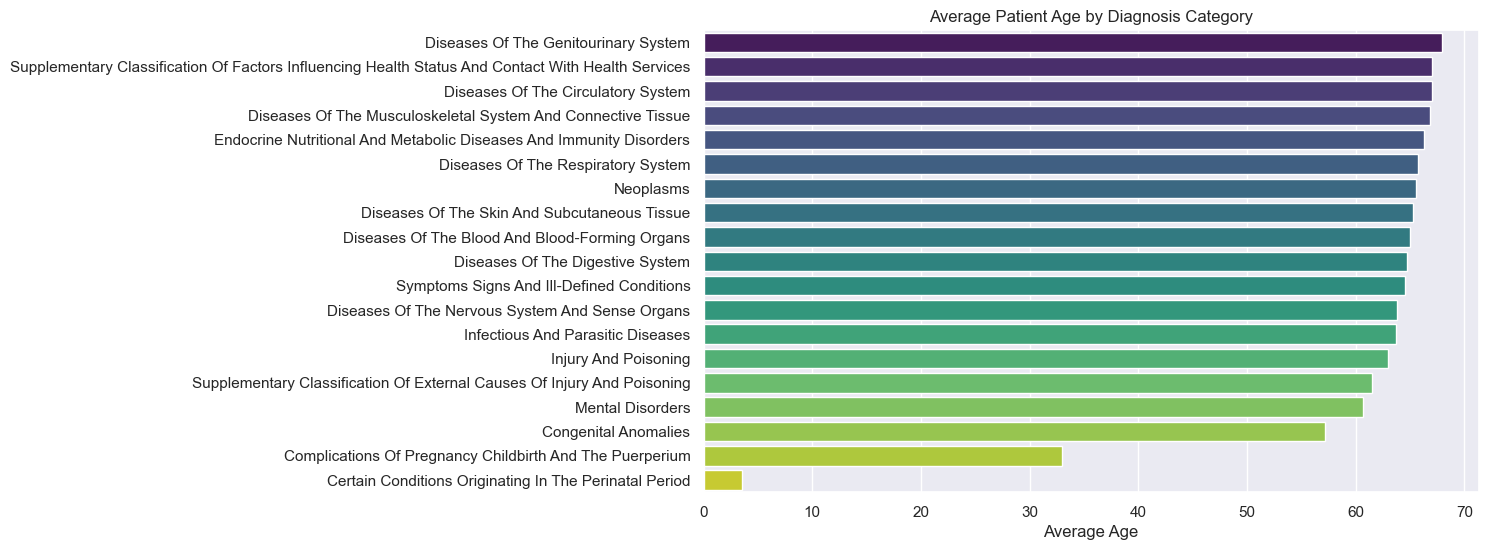

In [10]:
avg_age = df[icd_categories].multiply(df['age_at_admission'], axis="index").replace(0, np.nan).mean()

# Sort by average age
avg_age = avg_age.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y=avg_age.index, x=avg_age.values, palette="viridis")
plt.title('Average Patient Age by Diagnosis Category')
plt.xlabel('Average Age')
plt.show()

In [11]:
df.to_csv('../dataset/patient_stay_data.csv', index=False)

In [12]:
# # 2. Feature Extraction
# tfidf_matrix = process_diagnoses.tfidf_diagnoses(diagnoses)
# print(tfidf_matrix)

In [13]:
# from sklearn.cluster import KMeans
#
# num_clusters = 200
#
# km = KMeans(n_clusters=num_clusters)
#
# # Fit the KMeans object to the TF-IDF features
# km.fit(tfidf_matrix)
# clusters = km.labels_.tolist()
# print(clusters)
#
# diagnoses['cluster'] = clusters

In [14]:
# print(diagnoses.short_title[diagnoses.cluster == 33])

In [15]:
# from wordcloud import WordCloud
#
# text = ' '.join(diagnoses['short_title'])
# wordcloud = WordCloud(background_color='white', max_words=100, contour_color='black')
#
# wordcloud.generate(text)
#
# plt.figure(figsize=(10,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [16]:
# clusters_range = range(200, 250)
#
# sse = []
#
# for num_clusters in clusters_range:
#     km = KMeans(n_clusters=num_clusters)
#     km.fit(tfidf_matrix)
#     sse.append(km.inertia_)
#
# # Plot the SSE for each number of clusters
# plt.figure(figsize=(10,6))
# plt.plot(clusters_range, sse, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia (SSE)')
# plt.title('Elbow Method For Optimal Number of Clusters')
# plt.show()